In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn import metrics,linear_model,svm,preprocessing,tree,ensemble,naive_bayes,neighbors
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import learning_curve,cross_val_score, GridSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
import ta
import random
import seaborn as sns

## Loading Data

In [2]:
#Loading BTC/USD Prices
BTC = pd.read_csv('crypto_dfs/BTC-USD.csv')
features = BTC
features.set_index('Date',inplace=True)

#Loading BTC technical Analysis 
btc = pd.read_csv('crypto_dfs/btc.csv')
btc.set_index('date',inplace=True)
btc_2010 = btc.loc['2010-07-16':'2019-07-23']

In [3]:
features = features.join(btc_2010,how='outer')

## Feature Functions

In [4]:
def ExpMovingAvg(data, window):
    weights = np.exp(np.linspace(-1.,0.,window))
    weights /= weights.sum()
    
    a = np.convolve(data,weights)[:len(data)]
    a[:window] = None
    return a

def EMA(window):
    weights = np.exp(np.linspace(-1.,0.,window))
    weights /= weights.sum()
    
    a = np.convolve(features['Adj Close'],weights)[:len(features['Adj Close'])]
    a[:window] = None
    features['EMA_'+str(window)] = a
    
def RSISMA(window):
    delta = features['Adj Close'].diff()
    
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    roll_up = np.array(up.rolling(window=window).mean())
    roll_down = np.array(down.abs().rolling(window=window).mean())

    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))
    features['RSI_SMA'] = RSI
    
def RSIEMA(window):
    delta = features['Adj Close'].diff()
    
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    roll_up = ExpMovingAvg(up,window)
    roll_down = ExpMovingAvg(down.abs(),window)

    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))
    features['RSI_EMA'] = RSI
    
def target(data):
    deltas = data.diff()
    target = [1 if delta >= 0 else 0 for delta in deltas]
    target[0] = 1
    return target

def MA(window):
    features['MA_'+str(window)] = features['Adj Close'].rolling(window=window).mean()
    
def MovingAvg(data, window):
    SMA = data.rolling(window=window).mean()
    return np.array(SMA)

def UB(window):
    UB = features['High']*(1 + 4 * (features['High']-features['Low']) / (features['High'] + features['Low']))
    MA = MovingAvg(UB,window)
    features['UB_'+str(window)] = MA
    
def DB(window):
    DB = features['Low']*(1 - 4 * (features['High']-features['Low']) / (features['High'] + features['Low']))
    MA = MovingAvg(DB,window)
    features['DB_'+str(window)] = MA
    
def PROC(window):
    features['PROC_'+str(window)] = (features['Adj Close'] - features['Adj Close'].shift(window))/features['Adj Close'].shift(window)
    
def MFI(window):
    features['MFI_'+str(window)] = ta.momentum.money_flow_index(features['High'], features['Low'], features['Close'], features['Volume'], n=window, fillna=False)
    
def STO_SIG(window):
    features['STO_SIG_'+str(window)] = ta.momentum.stoch_signal(features['High'], features['Low'], features['Adj Close'], n=14, d_n=window, fillna=False)
       
def UO(s,m,l,ws,wm,wl):
    features['UO_'+str(s)+'_'+str(m)+'_'+str(l)] = ta.momentum.uo(features['High'], features['Low'], features['Adj Close'], s=s, m=m, len=l, ws=ws, wm=wm, wl=wl, fillna=False)
    
def CMF(window):
    features['CMF_'+str(window)] = ta.volume.chaikin_money_flow(features['High'], features['Low'], features['Adj Close'], features['Volume'], n=window, fillna=False)
    
def EMV(window):
    features['EMV_'+str(window)] = ta.volume.ease_of_movement(features['High'], features['Low'], features['Adj Close'], features['Volume'], n=window, fillna=False)

def FI(window):
    features['FI_'+str(window)] = ta.volume.force_index(features['Adj Close'], features['Volume'], n=window, fillna=False)
    
def OBV():
    features['OBV'] = ta.volume.on_balance_volume(features['Adj Close'], features['Volume'], fillna=False)
    
def ATR(window):
    features['ATR_'+str(window)] = ta.volatility.average_true_range(features['High'], features['Low'], features['Adj Close'], n=window, fillna=False)
    
def BBHB(window):
    factor = input('# of factors to use for BBHB: ')
    factor = int(factor)
    features['BBHB_'+str(window)+'_'+str(factor)] = ta.volatility.bollinger_hband(features['Adj Close'], n=window, ndev=factor, fillna=False)

def BBLB(window):
    factor = input('# of factors to use for BBLB: ')
    factor = int(factor)
    features['BBLB_'+str(window)+'_'+str(factor)] = ta.volatility.bollinger_lband(features['Adj Close'], n=window, ndev=factor, fillna=False)
    
def BBHBI(window,factor):
    features['BBHBI_'+str(window)+'_'+str(factor)] = ta.volatility.bollinger_hband_indicator(features['Adj Close'], n=window, ndev=factor, fillna=False)

def BBMA(window):
    features['BBMA_'+str(window)] = ta.volatility.bollinger_mavg(features['Adj Close'], n=window, fillna=False)
    
def ROI(window):
    """return on investment"""
    features['ROI_'+str(window)] = (features['Adj Close'] - features['Adj Close'].shift(window))/features['Adj Close'].shift(window)
    
def DCHB(window):
    '''Donchian channel HighBand'''
    features['DCHB_'+str(window)] = ta.volatility.donchian_channel_hband(features['Adj Close'], n=window, fillna=False)
    
def DCLB(window):
    '''Donchian channel LowBand'''
    features['DCLB_'+str(window)] = ta.volatility.donchian_channel_lband(features['Adj Close'], n=window, fillna=False)

def KCC(window):
    features['KCC_'+str(window)] = ta.volatility.keltner_channel_central(features['High'], features['Low'], features['Adj Close'], n=window, fillna=False)
    
def KCHB(window):
    features['KCHB_'+str(window)] = ta.volatility.keltner_channel_hband(features['High'], features['Low'], features['Adj Close'], n=window, fillna=False)
    
def KCLB(window):
    features['KCLB_'+str(window)] = ta.volatility.keltner_channel_lband(features['High'], features['Low'], features['Adj Close'], n=window, fillna=False)
    
def ADXP(window):
    features['ADXP_'+str(window)] = ta.trend.adx_neg(features['High'], features['Low'], features['Adj Close'], n=window, fillna=False)

def AID(window):    
    features['AID_'+str(window)] = ta.trend.aroon_down(features['Adj Close'], n=window, fillna=False)
    
def AIU(window):    
    features['AIU_'+str(window)] = ta.trend.aroon_up(features['Adj Close'], n=window, fillna=False)
    
def CCI(window):
    features['CCI_'+str(window)] = ta.trend.cci(features['High'], features['Low'], features['Adj Close'], n=window, c=0.015, fillna=False)
    
def DPO(window):
    features['DPO_'+str(window)] = ta.trend.dpo(features['Adj Close'], n=window, fillna=False)
    
def ICH_A(window1,window2):
    features['ICH_A_'+str(window1)+'_'+str(window2)] = ta.trend.ichimoku_a(features['High'], features['Low'], n1=window1, n2=window2, visual=False, fillna=False)
    
def ICH_B(window1,window2):
    features['ICH_B_'+str(window1)+'_'+str(window2)] = ta.trend.ichimoku_b(features['High'], features['Low'], n2=window1, n3=window2, visual=False, fillna=False)

## Fixed Parameter Features

In [5]:
features['STO_OS'] = ta.momentum.stoch(features['High'], features['Low'], features['Adj Close'], n=14, fillna=False)
features['WillR'] = ta.momentum.wr(features['High'], features['Low'], features['Adj Close'], lbp=14, fillna=False)
features['MACD'] = ExpMovingAvg(features['Adj Close'],12) - ExpMovingAvg(features['Adj Close'],26)
features['SIG_LI'] = ExpMovingAvg(features['MACD'],9)
features['AO'] = ta.momentum.ao(features['High'], features['Low'], s=5, len=34, fillna=False)
features['VPT'] = ta.volume.volume_price_trend(features['Adj Close'], features['Volume'], fillna=False)
features['NVI'] = ta.volume.negative_volume_index(features['Adj Close'], features['Volume'], fillna=False)
features['ADI'] = ta.volume.acc_dist_index(features['High'], features['Low'], features['Adj Close'], features['Volume'], fillna=False)
features['KST'] = ta.trend.kst(features['Adj Close'], r1=10, r2=15, r3=20, r4=30, n1=10, n2=10, n3=10, n4=15, fillna=False)

## Randomly Generated Features

In [6]:
functions = [MA,STO_SIG,EMA,PROC,RSISMA,UB,DB,CMF,EMV,FI,BBHB,BBLB,BBMA,ROI,DCHB,DCLB,KCC,KCHB,KCLB,AID,AIU,CCI,DPO]

def Randomize_feature(number_of_features):
    for n in range(number_of_features):
        i = random.randint(0,len(functions)-1)
        window = random.randint(2,120) #number of periods(days)
        functions[i](window)

In [7]:
Randomize_feature(50)

# of factors to use for BBLB: 2
# of factors to use for BBLB: 3
# of factors to use for BBLB: 4
# of factors to use for BBLB: 2
# of factors to use for BBHB: 1


In [8]:
features['target'] = target(features['Adj Close'])

In [9]:
features = features.dropna()

## Data Preprocessing

In [10]:
#Standardized Dataset
features_target = features.loc[:,'AdrActCnt':'target']
target = features_target['target']
All_features = features_target.drop(columns = ['target'])
Y, X = target,All_features
scaler = MinMaxScaler().fit(X)
rescaledX = scaler.transform(X)
X = pd.DataFrame(rescaledX, index = X.index, columns = X.columns)
Y = pd.DataFrame(Y, index = Y.index)
Y['Close']=features['Close']

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


# Feature Importance

In [11]:
##Feature Importance
model = ensemble.ExtraTreesClassifier(n_estimators=100)
model.fit(X,Y['target'])
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
#plt.figure(figsize=(20,20))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
#feat_importances.nsmallest(len(X.columns)).plot(kind='barh')
#plt.show()
feat_importances = feat_importances.sort_values(ascending=False).iloc[:30]
df1 = feat_importances
df1

STO_OS             0.055564
WillR              0.053859
ADI                0.027020
VPT                0.023202
CMF_16             0.017916
AID_23             0.017564
DPO_2              0.017440
AIU_94             0.016763
BlkCnt             0.016237
CMF_21             0.014987
NVTAdj             0.014421
AID_38             0.014279
ROI30d             0.014256
IssContNtv         0.014073
TxTfrValAdjNtv     0.013819
TxTfrValNtv        0.012933
IssTotNtv          0.012838
IssContPctAnn      0.012832
CCI_58             0.012791
TxTfrValMedUSD     0.012737
BlkSizeByte        0.012523
TxTfrValMedNtv     0.012215
CapMVRVCur         0.012170
TxTfrValMeanNtv    0.012149
TxTfr              0.012076
BlkSizeMeanByte    0.011891
TxTfrValAdjUSD     0.011757
AID_82             0.011611
FeeMeanNtv         0.011530
FI_51              0.011469
dtype: float64

In [12]:
##Feature Importance
model = ensemble.RandomForestClassifier(n_estimators=100)
model.fit(X,Y['target'])
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
#plt.figure(figsize=(20,20))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
#feat_importances.nsmallest(len(X.columns)).plot(kind='barh')
#plt.show()
feat_importances = feat_importances.sort_values(ascending=False).iloc[:30]
df2=feat_importances
df1.index.intersection(df2.index)

Index(['STO_OS', 'WillR', 'ADI', 'VPT', 'CMF_16', 'AID_23', 'DPO_2', 'AIU_94',
       'BlkCnt', 'CMF_21', 'NVTAdj', 'AID_38', 'ROI30d', 'IssContNtv',
       'TxTfrValAdjNtv', 'TxTfrValNtv', 'IssContPctAnn', 'CCI_58',
       'TxTfrValMedUSD', 'TxTfrValMedNtv', 'CapMVRVCur', 'TxTfrValMeanNtv',
       'FeeMeanNtv'],
      dtype='object')

# Top 20 best features

In [13]:
#chi-squared (chi²) statistical test for non-negative features to select 10 of the best features from the Mobile Price Range Prediction Dataset.
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2,k=10)
fit = bestfeatures.fit(X,Y['target'])
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(20,'Score'))  #print 10 best features

            Specs      Score
39         STO_OS  30.699805
40          WillR  30.699805
55         AID_23   6.832181
58         AIU_94   6.424690
66         AID_38   6.152267
59         CMF_16   5.904968
52         CMF_21   4.870144
56         CCI_92   3.958601
69         CCI_58   3.711485
23         ROI1yr   3.201141
81         AID_82   3.028334
36  VtyDayRet180d   2.569645
86         AID_83   2.537931
10      FeeMedNtv   2.208472
65     STO_SIG_76   1.980848
77     STO_SIG_87   1.794840
70    STO_SIG_106   1.694467
20       NVTAdj90   1.621862
95    STO_SIG_111   1.564689
19         NVTAdj   1.312081


# Heat Map Correlation Matrix 

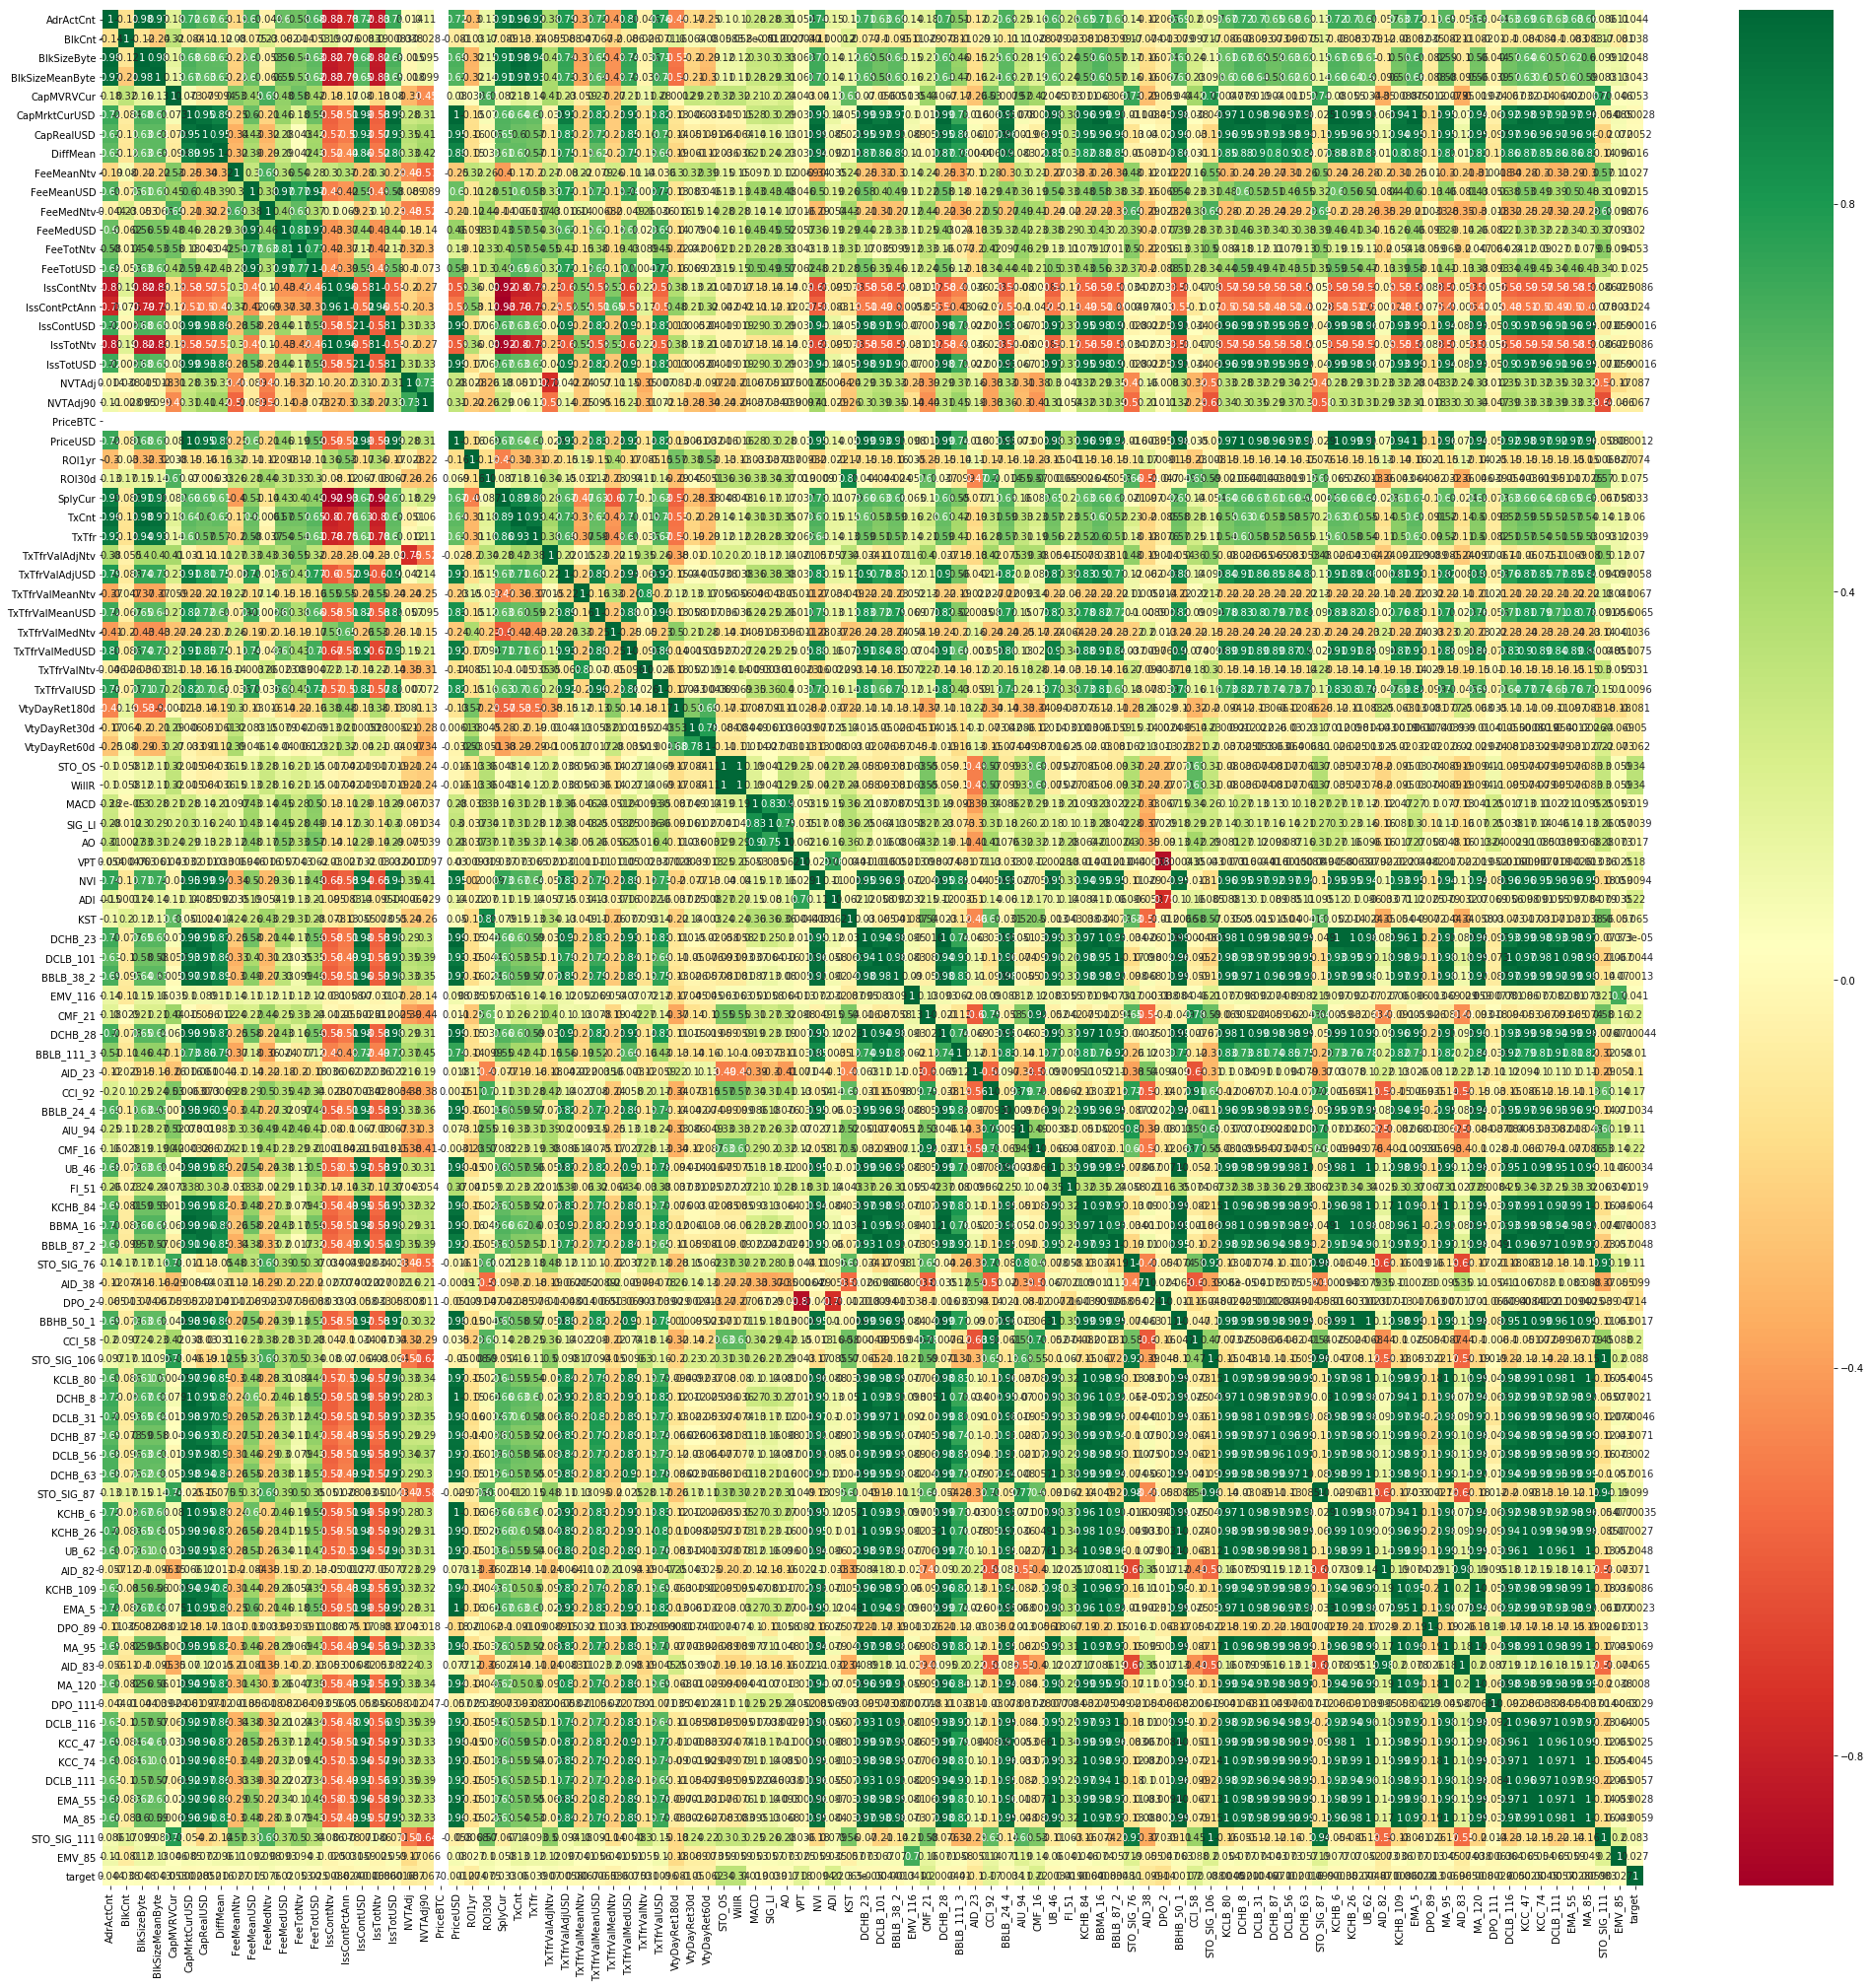

In [14]:
#Can be used after 
#get correlations of each features in dataset
corrmat = features_target.corr()
corr_features = corrmat.index
plt.figure(figsize=(35,35))
#plot heat map
g=sns.heatmap(features_target.corr(),annot=True,cmap="RdYlGn")

# Principle Component Analysis 

In [15]:
#We keep 25 components to make sure the sum of explained variation of the principal components is close to 98%
#To improve accuracy and efficiency
pca = PCA(n_components=25)
X = pd.DataFrame(pca.fit_transform(X),index=X.index)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Sum of Explained variation of principal component: {}'.format(sum(pca.explained_variance_ratio_)))

Explained variation per principal component: [0.57926321 0.15250451 0.05882322 0.03990003 0.03112821 0.02162053
 0.01527704 0.01450557 0.01259834 0.0107622  0.00951225 0.00686194
 0.00616945 0.00430636 0.0037897  0.0031768  0.00291243 0.00267505
 0.00230748 0.00191031 0.00180574 0.00172481 0.00152234 0.00125473
 0.00115084]
Sum of Explained variation of principal component: 0.9874631019658072


# Training Data Preparation

In [16]:
#Data Set Preparation 
X_test = X.iloc[int(len(X.index)*0.6):]
X_train = X.iloc[:int(len(X.index)*0.6)]
y_test = Y.iloc[int(len(Y.index)*0.6):]
Y_train = Y.iloc[:int(len(Y.index)*0.6)]
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.3,random_state=42)


In [17]:
print (X_train.shape, y_train.shape)
print (X_val.shape, y_val.shape)
print (X_test.shape, y_test.shape)

(828, 25) (828, 2)
(355, 25) (355, 2)
(790, 25) (790, 2)


In [18]:
def modelfit(alg, X, Y, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X, Y)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X, Y, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(Y.values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(Y, dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(10,10))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

# PCA Model


Model Report
Accuracy : 1
AUC Score (Train): 1.000000
CV Score : Mean - 0.6344469 | Std - 0.02362747 | Min - 0.5991069 | Max - 0.664627


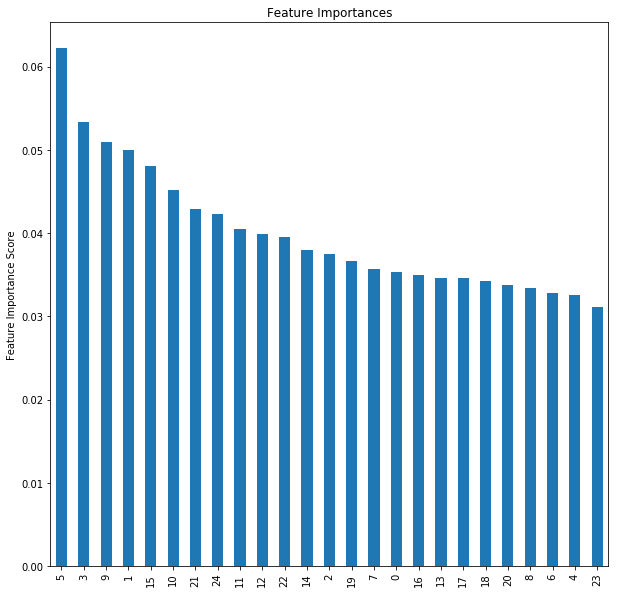

In [19]:
#XGBoost Hyperparameters tuning 
#creating a baseline model without tuning (assuming initial values)
XGB0 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0,
 subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
modelfit(XGB0, X_train, y_train['target'])

In [20]:
#XGBoost: learning_rate, n_estimators
param_test1 = {
    'learning_rate':[0.0001,0.01,0.1],
    'n_estimators':[100,200,500,800,1000]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch1.fit(X_train, y_train['target'])
gsearch1.best_params_, gsearch1.best_score_

({'learning_rate': 0.0001, 'n_estimators': 200}, 0.676015489447563)

In [21]:
#XGBoost: learning_rate, n_estimators; further testing 
param_test1b = {
    'learning_rate':[0.0001,0.005,0.001],
    'n_estimators':[100,200,300,400]
}
gsearch1b = GridSearchCV(estimator = XGBClassifier(max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),param_grid = param_test1b, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch1b.fit(X_train, y_train['target'])
gsearch1b.best_params_, gsearch1b.best_score_

({'learning_rate': 0.005, 'n_estimators': 100}, 0.6766117904907487)

In [22]:
#XGBoost: max_depth, min_child_weight
param_test2 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.005, n_estimators=100, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch2.fit(X_train, y_train['target'])
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 3, 'min_child_weight': 1}, 0.6887553585331931)

In [23]:
#XGBoost: max_depth, min_child_weight (step#2 further specify)
param_test2b = {
 'max_depth':[2,3,4],
 'min_child_weight':[1,2,3]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier(learning_rate =0.005, n_estimators=100, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch2b.fit(X_train, y_train['target'])
gsearch2b.best_params_, gsearch2b.best_score_

({'max_depth': 3, 'min_child_weight': 1}, 0.6887553585331931)

In [24]:
#XGBoost: gamma
param_test3 = {
 'gamma':[i/10.0 for i in range(0,10)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.005, n_estimators=100, max_depth=3,
 min_child_weight=1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch3.fit(X_train, y_train['target'])
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.9}, 0.6889865454599878)

In [25]:
#XGBoost: subsample, colsample_bytree
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.005, n_estimators=100, max_depth=3,
 min_child_weight=1, gamma=0.9, objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch4.fit(X_train, y_train['target'])
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.8}, 0.6889865454599878)

In [27]:
#XGBoost: subsample, colsample_bytree (step#2)
param_test4b = {
 'subsample':[i/100.0 for i in range(75,85,5)],
 'colsample_bytree':[i/100.0 for i in range(75,85,5)]
}
gsearch4b = GridSearchCV(estimator = XGBClassifier( learning_rate =0.005, n_estimators=100, max_depth=3,
 min_child_weight=1, gamma=0.9, objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4b, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch4b.fit(X_train, y_train['target'])
gsearch4b.best_params_, gsearch4b.best_score_

({'colsample_bytree': 0.75, 'subsample': 0.8}, 0.6892828740887985)

In [28]:
#XGBoost: reg_alpha
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.005, n_estimators=100, max_depth=3,
 min_child_weight=1, gamma=0.9, subsample=0.8, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch5.fit(X_train, y_train['target'])
gsearch5.best_params_, gsearch5.best_score_

({'reg_alpha': 1}, 0.6903452693033898)


Model Report
Accuracy : 0.7126
AUC Score (Train): 0.799481
CV Score : Mean - 0.6903453 | Std - 0.03275866 | Min - 0.6560069 | Max - 0.7377509


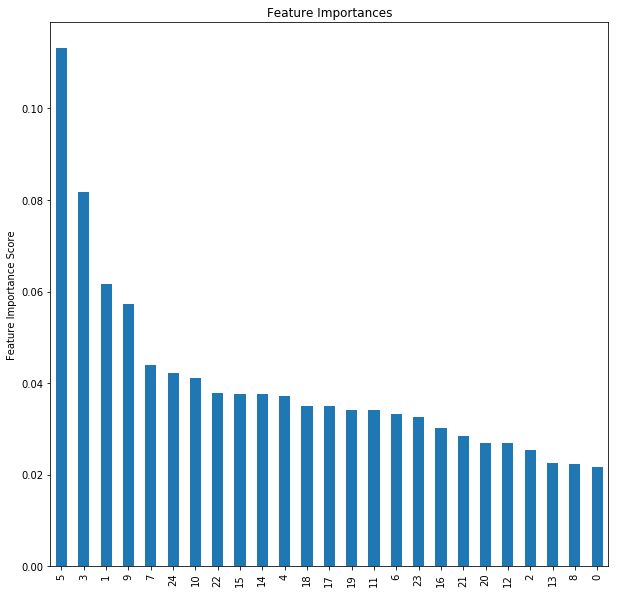

In [29]:
XGB1 = XGBClassifier(learning_rate=0.005, n_estimators=100, max_depth=3, min_child_weight=1, gamma=0.9,
 subsample=0.8,colsample_bytree=0.75,reg_alpha=1, objective='binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
modelfit(XGB1, X_train, y_train['target'])


Model Report
Accuracy : 0.7126
AUC Score (Train): 0.793844
CV Score : Mean - 0.6888084 | Std - 0.03137297 | Min - 0.6575915 | Max - 0.7355372


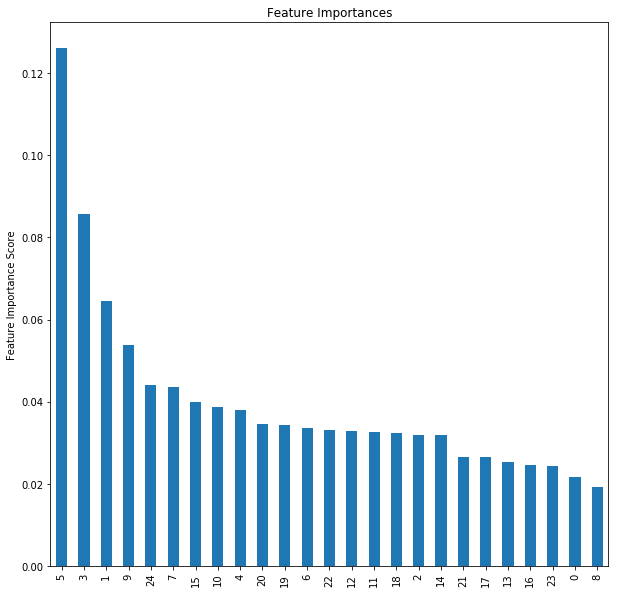

In [30]:
XGB2 = XGBClassifier(learning_rate=0.001, n_estimators=200, max_depth=3, min_child_weight=1, gamma=0.9,
 subsample=0.8,colsample_bytree=0.75,reg_alpha=1, objective='binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
modelfit(XGB2, X_train, y_train['target'])


Model Report
Accuracy : 0.7198
AUC Score (Train): 0.801912
CV Score : Mean - 0.68696 | Std - 0.03166461 | Min - 0.6533353 | Max - 0.7358323


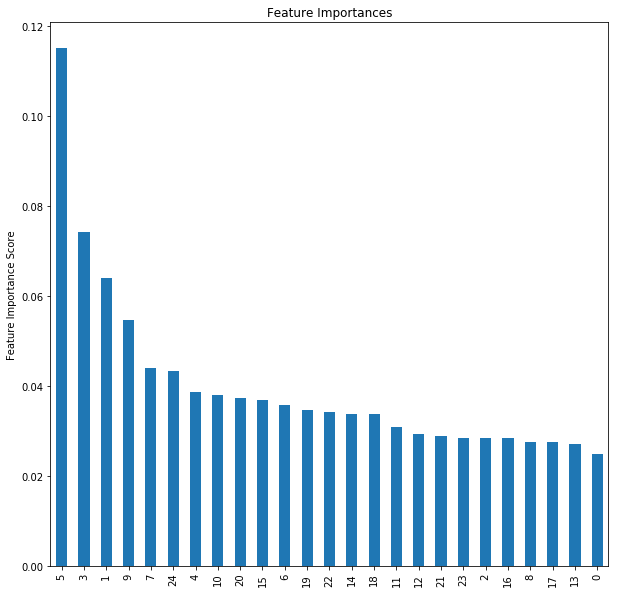

In [32]:
XGB3 = XGBClassifier(learning_rate=0.0005, n_estimators=1000, max_depth=3, min_child_weight=1, gamma=0.9,
 subsample=0.8,colsample_bytree=0.75,reg_alpha=1, objective='binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
modelfit(XGB3, X_train, y_train['target'])

In [33]:
#Default XGBoost
x_prediction = X_val
model = XGBClassifier()        
print("# Training...")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))

# Training...
# Predicting...
- probabilities: [0.66678166 0.31811348 0.22817393 0.5167422  0.39894846]
- accuracy:  0.6028169014084507
- validation logloss: 0.6829074461695174


In [34]:
#Initial XGB0
x_prediction = X_val
model = XGB0        
print("# Training...")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))

# Training...
# Predicting...
- probabilities: [0.994169   0.05663828 0.03585894 0.45176825 0.98616254]
- accuracy:  0.5915492957746479
- validation logloss: 1.09729651124811


In [36]:
#XBG1
x_prediction = X_val
model = XGB1    
print("# Training...")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))
x_prediction = X_test
y_prediction = model.predict(x_prediction)
results = y_prediction
prob = pd.DataFrame(data={'PCA prediction': results},index=X_test.index)
Close = pd.DataFrame(data={'PCA Close': y_test['Close']})
prob = prob.join(Close)
prob

# Training...
# Predicting...
- probabilities: [0.56641454 0.46902835 0.42327115 0.4804444  0.50318694]
- accuracy:  0.6084507042253521
- validation logloss: 0.6654627249274455


PCA prediction     PCA Close
2016-05-30               1    528.919983
2016-05-31               1    537.400024
2016-06-01               1    537.099976
2016-06-02               1    567.030029
2016-06-03               1    571.950012
...                    ...           ...
2019-07-16               0   9696.150391
2019-07-17               0  10638.349609
2019-07-18               0  10532.940430
2019-07-19               0  10759.419922
2019-07-20               0  10586.709961

[796 rows x 2 columns]

In [37]:
#assuming zero risk free rate
#sharpe ratio 
#max drawdown
#absolute return
performance_df = pd.DataFrame(index=['Sharpe Ratio','Max Drawdown','Absolute return'])
def performance(prediction, close):
    Investment=[]
    Capital=[]
    for i in range(len(prediction)):
        if i==0 and prediction.iloc[i]==1:
            Capital.append(close.iloc[i])
        if i>0 and prediction.iloc[i-1]==0 and prediction.iloc[i]==1:
            Capital.append(close.iloc[i])
        if i>0 and prediction.iloc[i-1]==1 and prediction.iloc[i]==0:
            Investment.append(close.iloc[i])
        if i==len(prediction)-1 and prediction.iloc[i]==1:
            Investment.append(close.iloc[i])
    absolute_return=np.log(np.sum(Investment)/np.sum(Capital))
    returns = pd.DataFrame(np.log(np.array(Investment)/np.array(Capital))).replace([np.inf, -np.inf], np.nan).dropna()
    avg_return = float(np.mean(returns))
    std = float(np.std(returns))
    SR = avg_return/std
    max_drawdown = (min(close)-max(close))/max(close)
    return SR, max_drawdown, absolute_return
results = performance(prob['PCA prediction'],prob['PCA Close'])
performance_df['PCA'] = results
performance_df

PCA
Sharpe Ratio     0.273371
Max Drawdown    -0.960240
Absolute return  0.039091

# Benchmark learning (all features included)

In [38]:
features_target = features.loc[:,'AdrActCnt':'target']
target = features_target['target']
All_features = features_target.drop(columns = ['target'])
Y, X = target,All_features
scaler = MinMaxScaler().fit(X)
rescaledX = scaler.transform(X)
X = pd.DataFrame(rescaledX, index = X.index, columns = X.columns)
Y = pd.DataFrame(Y, index = Y.index)
Y['Close']=features['Close']

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [39]:
#Data Set Preparation 
X_test = X.iloc[int(len(X.index)*0.6):]
X_train = X.iloc[:int(len(X.index)*0.6)]
y_test = Y.iloc[int(len(Y.index)*0.6):]
Y_train = Y.iloc[:int(len(Y.index)*0.6)]
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.3,random_state=42)

In [40]:
print (X_train.shape, y_train.shape)
print (X_val.shape, y_val.shape)
print (X_test.shape, y_test.shape)

(828, 97) (828, 2)
(355, 97) (355, 2)
(790, 97) (790, 2)



Model Report
Accuracy : 1
AUC Score (Train): 1.000000
CV Score : Mean - 0.7885794 | Std - 0.02166489 | Min - 0.7644771 | Max - 0.8267414


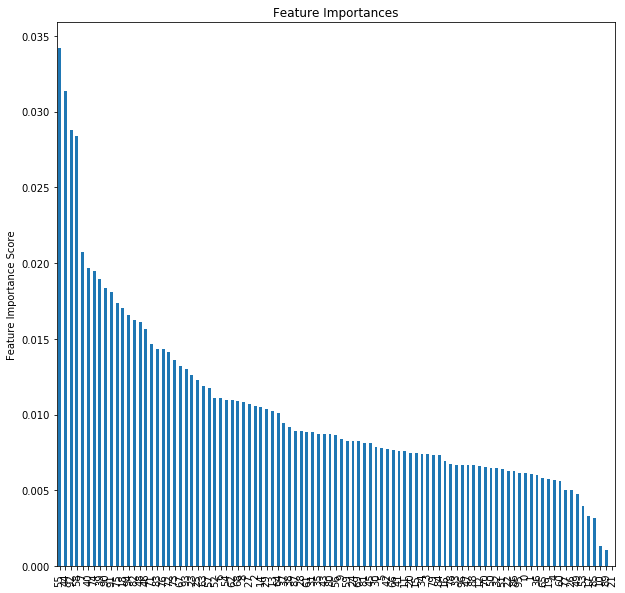

In [41]:
#XGBoost Hyperparameters tuning 
#creating a baseline model without tuning (assuming initial values)
XGB0 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0,
 subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
modelfit(XGB0, X_train, y_train['target'])

In [43]:
#XGBoost: n_estimators
param_test1 = {
    'learning_rate':[0.0001,0.01,0.1],
    'n_estimators':[100,200,500,800,1000]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch1.fit(X_train, y_train['target'])
gsearch1.best_params_, gsearch1.best_score_

({'learning_rate': 0.01, 'n_estimators': 500}, 0.8270179258943304)

In [44]:
#XGBoost: n_estimators; further testing 
param_test1b = {
 'learning_rate':[0.001,0.005,0.01],
'n_estimators':[300,400,500,600]
}
gsearch1b = GridSearchCV(estimator = XGBClassifier(max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),param_grid = param_test1b, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch1b.fit(X_train, y_train['target'])
gsearch1b.best_params_, gsearch1b.best_score_

({'learning_rate': 0.01, 'n_estimators': 400}, 0.8281461601047913)

In [45]:
#XGBoost: max_depth, min_child_weight
param_test2 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.01, n_estimators=400, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch2.fit(X_train, y_train['target'])
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 3, 'min_child_weight': 1}, 0.8299396381623143)

In [46]:
#XGBoost: max_depth, min_child_weight (step#2 further specify)
param_test2b = {
 'max_depth':[2,3,4],
 'min_child_weight':[1,2,3]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier(learning_rate =0.01, n_estimators=400, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch2b.fit(X_train, y_train['target'])
gsearch2b.best_params_, gsearch2b.best_score_

({'max_depth': 4, 'min_child_weight': 2}, 0.8339321599408424)

In [47]:
#XGBoost: gamma
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.01, n_estimators=400, max_depth=4,
 min_child_weight=2, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch3.fit(X_train, y_train['target'])
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.1}, 0.8340495689193339)

In [48]:
#XGBoost: subsample, colsample_bytree
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.01, n_estimators=400, max_depth=4,
 min_child_weight=2, gamma=0.1, objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch4.fit(X_train, y_train['target'])
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.9, 'subsample': 0.9}, 0.8401673615795169)

In [49]:
#XGBoost: subsample, colsample_bytree
param_test4b = {
 'subsample':[i/100.0 for i in range(85,95,5)],
 'colsample_bytree':[i/100.0 for i in range(85,95,5)]
}
gsearch4b = GridSearchCV(estimator = XGBClassifier(learning_rate =0.01, n_estimators=400, max_depth=4,
 min_child_weight=2, gamma=0.1, objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4b, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch4b.fit(X_train, y_train['target'])
gsearch4b.best_params_, gsearch4b.best_score_

({'colsample_bytree': 0.9, 'subsample': 0.9}, 0.8401673615795169)

In [50]:
#XGBoost: reg_alpha
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.01, n_estimators=400, max_depth=4,
 min_child_weight=2, gamma=0.1, subsample=0.9, colsample_bytree=0.9,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch5.fit(X_train, y_train['target'])
gsearch5.best_params_, gsearch5.best_score_

({'reg_alpha': 1e-05}, 0.8401673615795169)

In [51]:
#XGBoost: reg_alpha (step#2)
param_test5b = {
 'reg_alpha':[1e-6,1e-5,1e-4,1e-3]
}
gsearch5b = GridSearchCV(estimator = XGBClassifier(learning_rate =0.01, n_estimators=400, max_depth=4,
 min_child_weight=2, gamma=0.1, subsample=0.9, colsample_bytree=0.9,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch5b.fit(X_train, y_train['target'])
gsearch5b.best_params_, gsearch5.best_score_

({'reg_alpha': 1e-05}, 0.8401673615795169)


Model Report
Accuracy : 0.8708
AUC Score (Train): 0.960350
CV Score : Mean - 0.8401674 | Std - 0.01906711 | Min - 0.8150389 | Max - 0.8617424


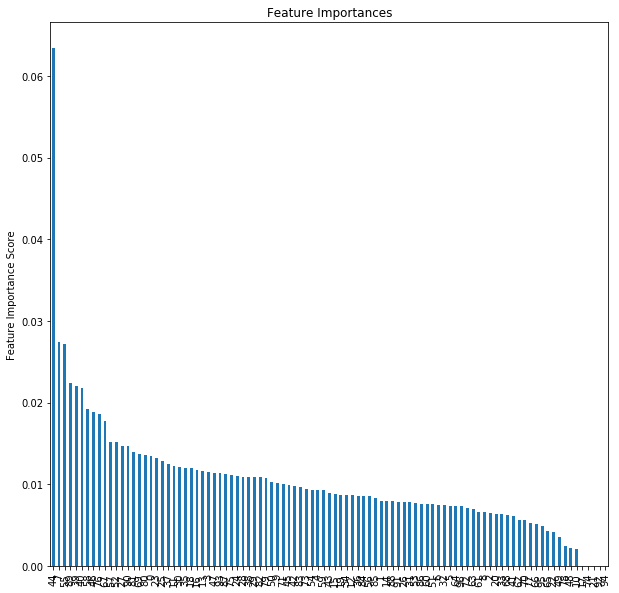

In [52]:
XGB1 = XGBClassifier(learning_rate=0.01, n_estimators=400, max_depth=4, min_child_weight=2, gamma=0.1,
 subsample=0.9,colsample_bytree=0.9,reg_alpha=1e-5, objective='binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
modelfit(XGB1, X_train, y_train['target'])


Model Report
Accuracy : 0.8708
AUC Score (Train): 0.958902
CV Score : Mean - 0.8402046 | Std - 0.01668407 | Min - 0.8187842 | Max - 0.8630536


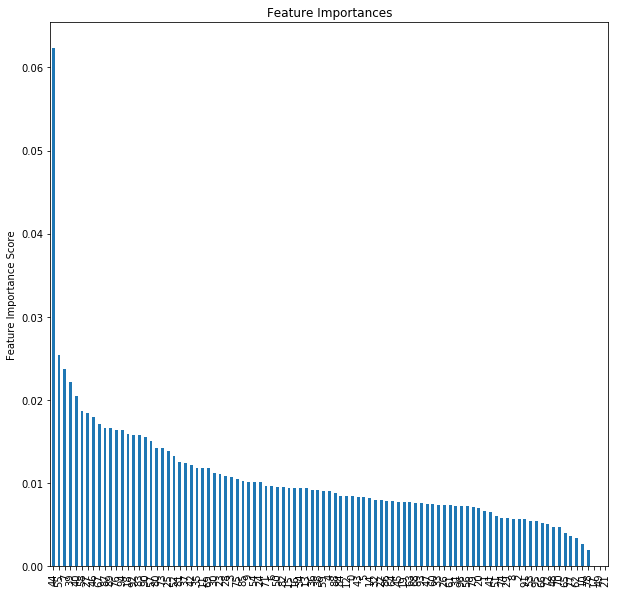

In [53]:
XGB2 = XGBClassifier(learning_rate=0.005, n_estimators=800, max_depth=4, min_child_weight=2, gamma=0.1,
 subsample=0.9,colsample_bytree=0.9,reg_alpha=1e-5, objective='binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
modelfit(XGB2, X_train, y_train['target'])


Model Report
Accuracy : 0.8684
AUC Score (Train): 0.958264
CV Score : Mean - 0.8405133 | Std - 0.01748051 | Min - 0.8206569 | Max - 0.865676


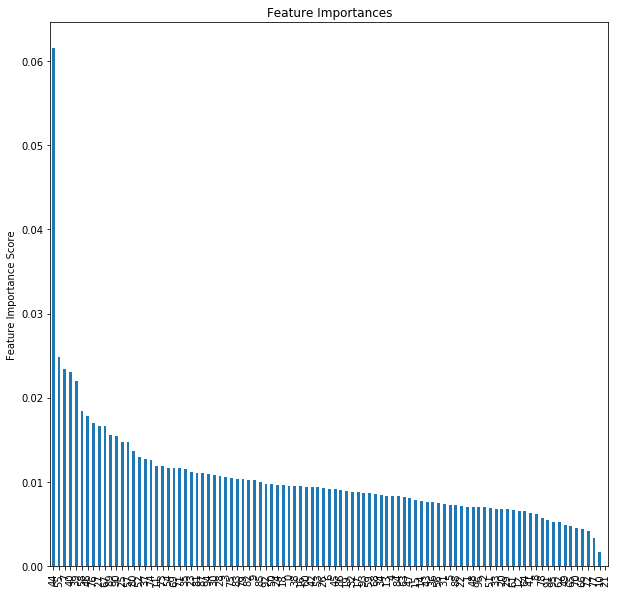

In [54]:
XGB3 = XGBClassifier(learning_rate=0.0025, n_estimators=1600, max_depth=4, min_child_weight=2, gamma=0.1,
 subsample=0.9,colsample_bytree=0.9,reg_alpha=1e-5, objective='binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
modelfit(XGB3, X_train, y_train['target'])

#since XGB1 has the overall best performance out of all models in terms of AUC and CV scores, we will pick XGB1 as our prediction model

In [55]:
#Default XGBoost
x_prediction = X_val
model = XGBClassifier()        
print("# Training...")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))

# Training...
# Predicting...
- probabilities: [0.7531403  0.3326786  0.23907837 0.37125412 0.0576679 ]
- accuracy:  0.7690140845070422
- validation logloss: 0.4647081329290506


In [56]:
#Initial XGB0
x_prediction = X_val
model = XGB0        
print("# Training...")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))
print('\n')

# Training...
# Predicting...
- probabilities: [0.9600378  0.05432251 0.12440178 0.79114306 0.48014447]
- accuracy:  0.7323943661971831
- validation logloss: 0.7232947735588977




In [58]:
#XGB1
x_prediction = X_val
model = XGB1       
print("# Training...")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))
print('\n')
x_prediction = X_test
y_prediction = model.predict(x_prediction)
results = y_prediction
prob = pd.DataFrame(data={'Bench prediction': results},index=X_test.index)
Close = pd.DataFrame(data={'Bench Close': y_test['Close']})
prob = prob.join(Close)
prob

# Training...
# Predicting...
- probabilities: [0.7254482  0.360293   0.2982673  0.42720512 0.11475349]
- accuracy:  0.7830985915492957
- validation logloss: 0.4736670323660676




Bench prediction   Bench Close
2016-05-30                 0    528.919983
2016-05-31                 1    537.400024
2016-06-01                 1    537.099976
2016-06-02                 1    567.030029
2016-06-03                 1    571.950012
...                      ...           ...
2019-07-16                 1   9696.150391
2019-07-17                 1  10638.349609
2019-07-18                 1  10532.940430
2019-07-19                 1  10759.419922
2019-07-20                 1  10586.709961

[796 rows x 2 columns]

In [59]:
#assuming zero risk free rate
#sharpe ratio 
#max drawdown
#absolute return
results = performance(prob['Bench prediction'],prob['Bench Close'])
performance_df['Benchmark'] = results
performance_df

PCA  Benchmark
Sharpe Ratio     0.273371   0.150987
Max Drawdown    -0.960240  -0.960240
Absolute return  0.039091   0.013880

# PCA-DWT

In [60]:
features_target = features.loc[:,'AdrActCnt':'target']
target = features_target['target']
All_features = features_target.drop(columns = ['target'])
Y, X = target,All_features
scaler = MinMaxScaler().fit(X)
rescaledX = scaler.transform(X)
X = pd.DataFrame(rescaledX, index = X.index, columns = X.columns)
Y = pd.DataFrame(Y, index = Y.index)
Y['Close']=features['Close']

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [61]:
#We keep 25 components to make sure the sum of explained variation of the principal components is close to 98%
#To improve accuracy and efficiency
pca = PCA(n_components=25)
X = pd.DataFrame(pca.fit_transform(X),index=X.index)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Sum of Explained variation of principal component: {}'.format(sum(pca.explained_variance_ratio_)))

Explained variation per principal component: [0.57926321 0.15250451 0.05882322 0.03990003 0.03112821 0.02162053
 0.01527704 0.01450557 0.01259834 0.0107622  0.00951225 0.00686194
 0.00616945 0.00430636 0.0037897  0.0031768  0.00291243 0.00267505
 0.00230748 0.0019103  0.00180574 0.00172475 0.00152202 0.00125429
 0.00115073]
Sum of Explained variation of principal component: 0.9874621657922874


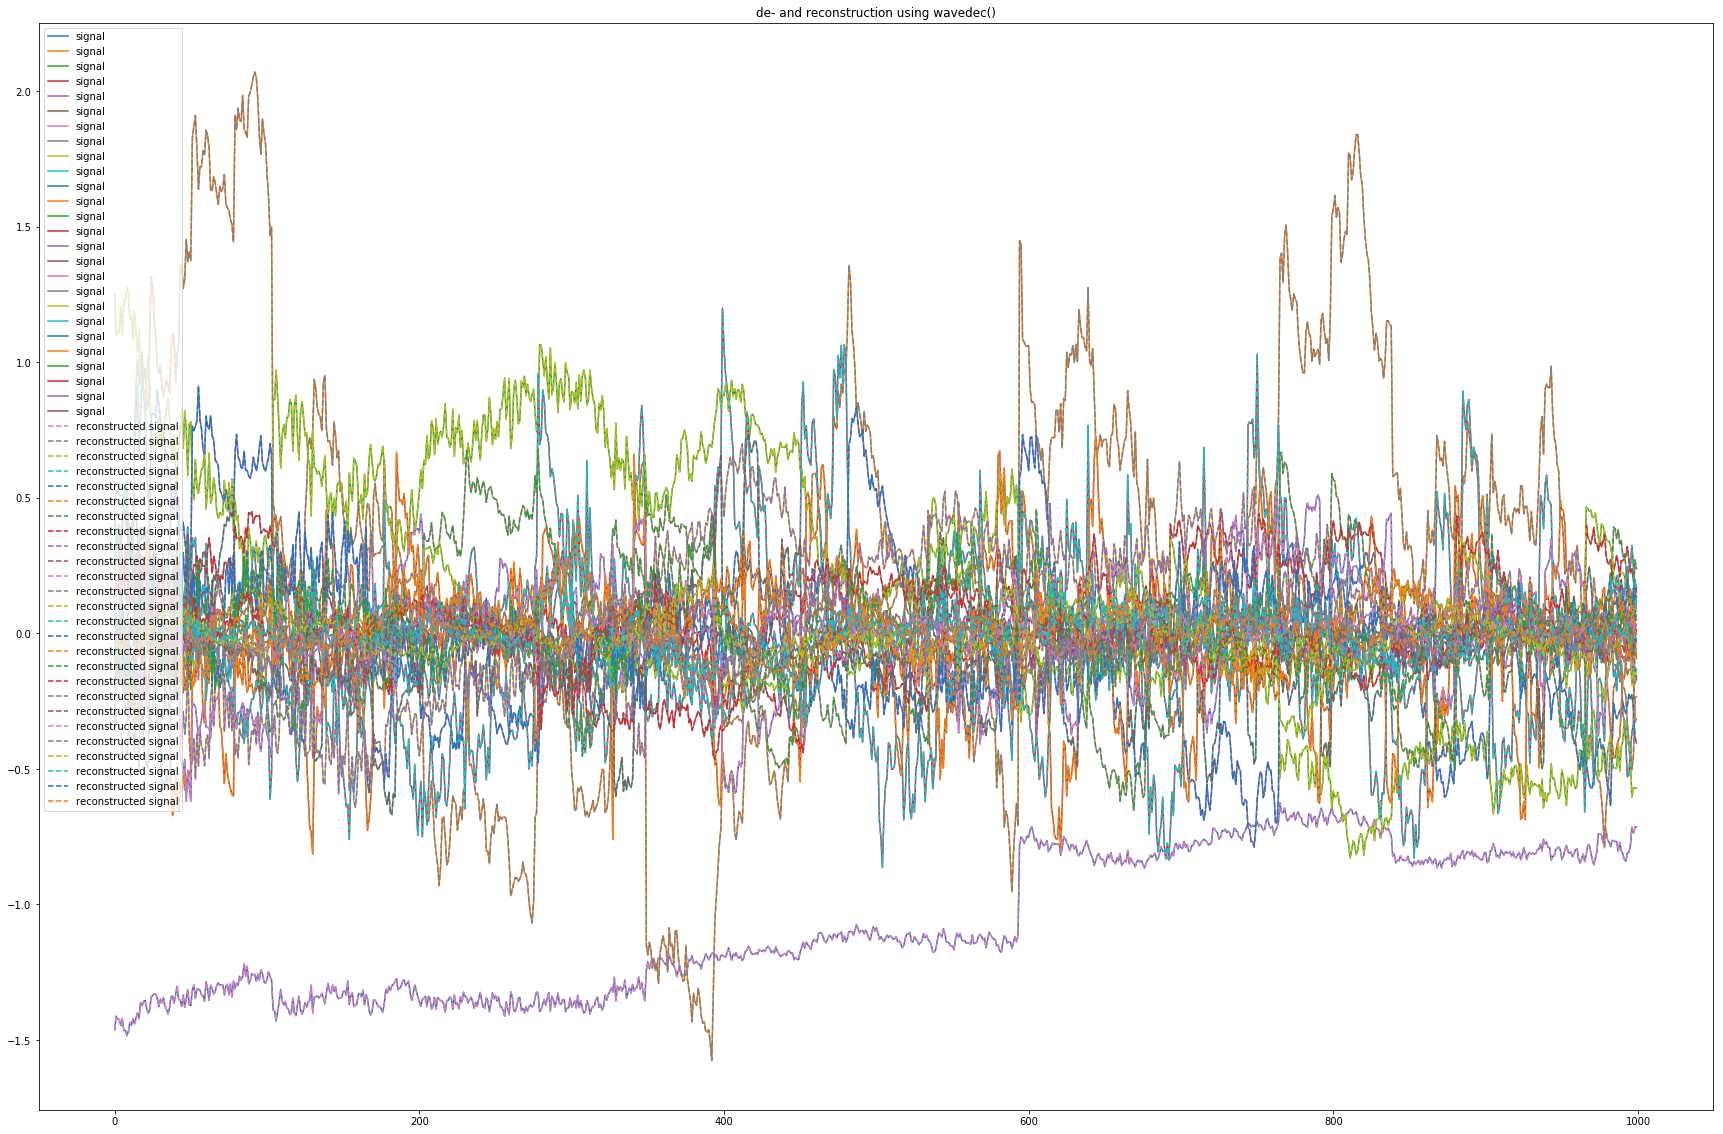

In [62]:
import pywt
coeffs = pywt.wavedec(X, 'db2', level=3)
X = pywt.waverec(coeffs, 'db2')
 
fig, ax = plt.subplots(figsize=(30,20))
ax.plot(X[:1000], label='signal')
ax.plot(X[:1000], label='reconstructed signal', linestyle='--')
ax.legend(loc='upper left')
ax.set_title('de- and reconstruction using wavedec()')
plt.show()

In [63]:
#Data Set Preparation 
X_test = X[int(len(X)*0.6):]
X_train = X[:int(len(X)*0.6)]
y_test = Y[int(len(Y)*0.6):]
Y_train = Y[:int(len(Y)*0.6)]
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.3,random_state=42)

In [64]:
print (X_train.shape, y_train.shape)
print (X_val.shape, y_val.shape)
print (X_test.shape, y_test.shape)

(828, 26) (828, 2)
(355, 26) (355, 2)
(790, 26) (790, 2)



Model Report
Accuracy : 1
AUC Score (Train): 1.000000
CV Score : Mean - 0.637146 | Std - 0.02560012 | Min - 0.5946413 | Max - 0.6679779


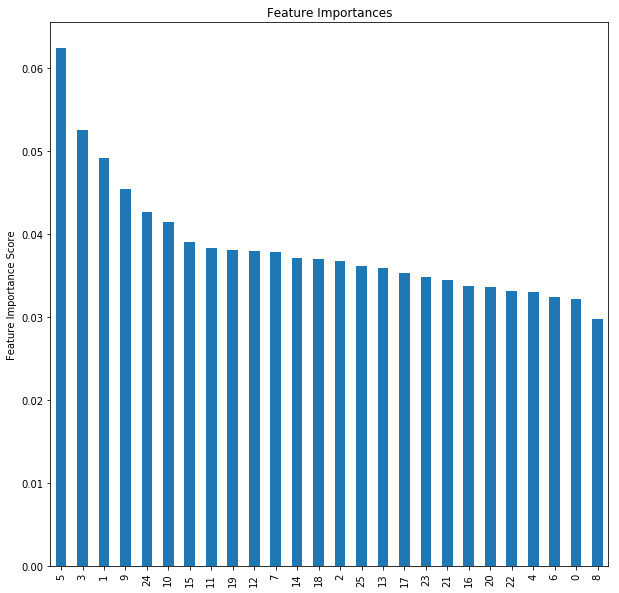

In [65]:
#XGBoost Hyperparameters tuning 
#creating a baseline model without tuning (assuming initial values)
XGB0 = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0,
 subsample=0.8,colsample_bytree=0.8,objective='binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
modelfit(XGB0, X_train, y_train['target'])

In [66]:
#XGBoost: n_estimators
param_test1 = {
    'learning_rate':[0.0001,0.01,0.1],
    'n_estimators':[100,200,500,800,1000]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),param_grid = param_test1, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch1.fit(X_train, y_train['target'])
gsearch1.best_params_, gsearch1.best_score_

({'learning_rate': 0.0001, 'n_estimators': 100}, 0.6731144536430542)

In [67]:
#XGBoost: n_estimators; further testing 
param_test1b = {
    'learning_rate':[0.0001,0.001,0.005],
    'n_estimators':[100]
}
gsearch1b = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),param_grid = param_test1b, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch1b.fit(X_train, y_train['target'])
gsearch1b.best_params_, gsearch1b.best_score_

({'learning_rate': 0.0001, 'n_estimators': 100}, 0.6731144536430542)

In [68]:
#XGBoost: max_depth, min_child_weight
param_test2 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.0001, n_estimators=100, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch2.fit(X_train, y_train['target'])
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 3, 'min_child_weight': 5}, 0.6877127554093846)

In [69]:
#XGBoost: max_depth, min_child_weight (step#2 further specify)
param_test2b = {
 'max_depth':[2,3,4],
 'min_child_weight':[4,5,6]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier(learning_rate =0.0001, n_estimators=100, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch2b.fit(X_train, y_train['target'])
gsearch2b.best_params_, gsearch2b.best_score_

({'max_depth': 3, 'min_child_weight': 6}, 0.6881175514985525)

In [70]:
#XGBoost: gamma
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.0001, n_estimators=100, max_depth=3,
 min_child_weight=6, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch3.fit(X_train, y_train['target'])
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.3}, 0.6881470674371593)

In [71]:
#XGBoost: subsample, colsample_bytree
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.0001, n_estimators=100, max_depth=3,
 min_child_weight=6, gamma=0.3, objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch4.fit(X_train, y_train['target'])
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.9, 'subsample': 0.6}, 0.6937186366578605)

In [72]:
#XGBoost: subsample, colsample_bytree (step#2)
param_test4b = {
 'subsample':[i/100.0 for i in range(55,65,5)],
 'colsample_bytree':[i/100.0 for i in range(85,95,5)]
}
gsearch4b = GridSearchCV(estimator = XGBClassifier( learning_rate =0.0001, n_estimators=100, max_depth=3,
 min_child_weight=6, gamma=0.3, objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4b, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch4b.fit(X_train, y_train['target'])
gsearch4b.best_params_, gsearch4b.best_score_

({'colsample_bytree': 0.9, 'subsample': 0.55}, 0.6952200506337382)

In [73]:
#XGBoost: reg_alpha
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.0001, n_estimators=100, max_depth=3,
 min_child_weight=6, gamma=0.3, subsample=0.55, colsample_bytree=0.9,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)
gsearch5.fit(X_train, y_train['target'])
gsearch5.best_params_, gsearch5.best_score_

({'reg_alpha': 1e-05}, 0.6952200506337382)


Model Report
Accuracy : 0.7005
AUC Score (Train): 0.775206
CV Score : Mean - 0.6952201 | Std - 0.0320457 | Min - 0.6642562 | Max - 0.7510331


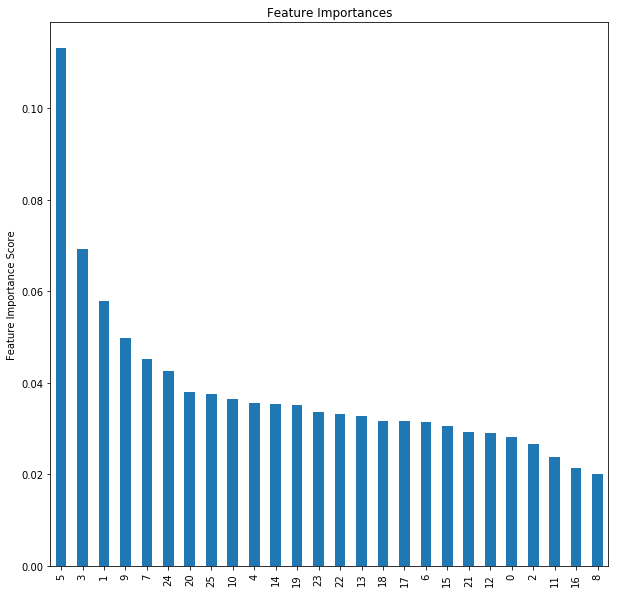

In [74]:
XGB1 = XGBClassifier(learning_rate=0.0001, n_estimators=100, max_depth=3, min_child_weight=6, gamma=0.3,
 subsample=0.55,colsample_bytree=0.9,reg_alpha=1e-5, objective='binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
modelfit(XGB1, X_train, y_train['target'])


Model Report
Accuracy : 0.7114
AUC Score (Train): 0.777409
CV Score : Mean - 0.6955099 | Std - 0.0333953 | Min - 0.664794 | Max - 0.755608


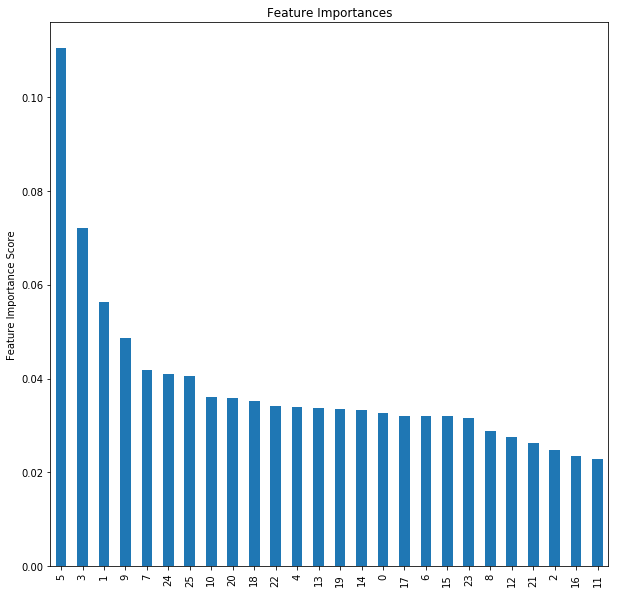

In [75]:
XGB2 = XGBClassifier(learning_rate=0.00005, n_estimators=200, max_depth=3, min_child_weight=6, gamma=0.3,
 subsample=0.55,colsample_bytree=0.9,reg_alpha=1e-5, objective='binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
modelfit(XGB2, X_train, y_train['target'])


Model Report
Accuracy : 0.7174
AUC Score (Train): 0.779114
CV Score : Mean - 0.6928326 | Std - 0.03360513 | Min - 0.6635696 | Max - 0.7497786


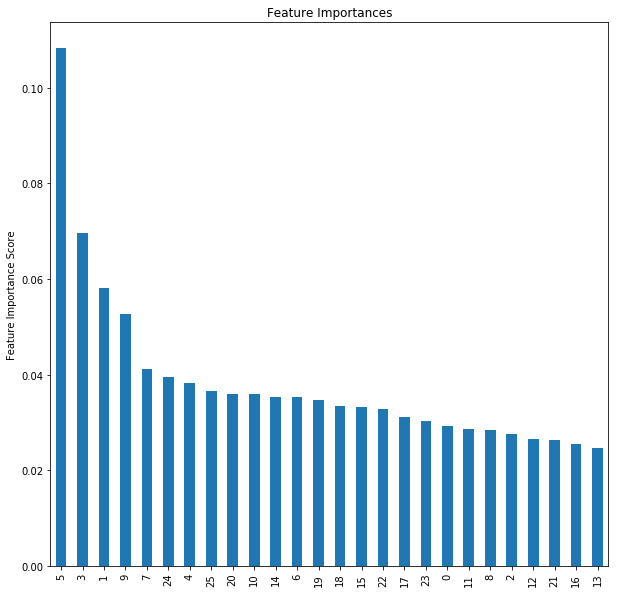

In [76]:
XGB3 = XGBClassifier(learning_rate=0.00001, n_estimators=1000, max_depth=3, min_child_weight=6, gamma=0.3,
 subsample=0.55,colsample_bytree=0.9,reg_alpha=1e-5, objective='binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
modelfit(XGB3, X_train, y_train['target'])

In [82]:
#Default XGBoost
x_prediction = X_val
model = XGBClassifier()        
print("# Training...")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))
x_prediction = X_test
y_prediction = model.predict(x_prediction)
results = y_prediction
prob = pd.DataFrame(data={'PCA_DWT prediction': results},index=y_test.index)
Close = pd.DataFrame(data={'PCA_DWT Close': y_test['Close']})
prob = prob.join(Close)
prob

# Training...
# Predicting...
- probabilities: [0.5990526  0.35883692 0.20697546 0.58395594 0.5057708 ]
- accuracy:  0.6140845070422535
- validation logloss: 0.6866310211344504


PCA_DWT prediction  PCA_DWT Close
2016-05-30                   1     528.919983
2016-05-31                   1     537.400024
2016-06-01                   1     537.099976
2016-06-02                   1     567.030029
2016-06-03                   1     571.950012
...                        ...            ...
2019-07-16                   0    9696.150391
2019-07-17                   0   10638.349609
2019-07-18                   0   10532.940430
2019-07-19                   0   10759.419922
2019-07-20                   1   10586.709961

[796 rows x 2 columns]

In [78]:
#Initial XGB0
x_prediction = X_val
model = XGB0        
print("# Training...")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))
print('\n')

# Training...
# Predicting...
- probabilities: [0.9883469  0.01951543 0.01169692 0.6774189  0.9481117 ]
- accuracy:  0.6028169014084507
- validation logloss: 1.1102118931873866




In [81]:
#XGB2
x_prediction = X_val
model = XGB2
print("# Training...")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))
print('\n')

# Training...
# Predicting...
- probabilities: [0.5018621  0.4991624  0.4982058  0.49933746 0.5000599 ]
- accuracy:  0.6112676056338028
- validation logloss: 0.6922634381643483




#since default xgboost performs better with higher accuracy and lower validation loss, we will pick default xgboost as our predicition model.

In [83]:
results = performance(prob['PCA_DWT prediction'],prob['PCA_DWT Close'])
performance_df['PCA_DWT'] = results
performance_df

PCA  Benchmark   PCA_DWT
Sharpe Ratio     0.273371   0.150987  0.246176
Max Drawdown    -0.960240  -0.960240 -0.960240
Absolute return  0.039091   0.013880  0.019120

# SGD

In [91]:
features_target = features.loc[:,'AdrActCnt':'target']
target = features_target['target']
All_features = features_target.drop(columns = ['target'])
Y, X = target,All_features
scaler = MinMaxScaler().fit(X)
rescaledX = scaler.transform(X)
X = pd.DataFrame(rescaledX, index = X.index, columns = X.columns)
Y = pd.DataFrame(Y, index = Y.index)
Y['Close']=features['Close']

In [92]:
#Data Set Preparation 
X_test = X[int(len(X)*0.6):]
X_train = X[:int(len(X)*0.6)]
y_test = Y[int(len(Y)*0.6):]
Y_train = Y[:int(len(Y)*0.6)]
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.3,random_state=42)

print (X_train.shape, y_train.shape)
print (X_val.shape, y_val.shape)

(828, 97) (828, 2)
(355, 97) (355, 2)


-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    3.2s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    3.3s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    3.3s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    3.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    3.3s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    3.3s finished


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    2.4s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.5s finished


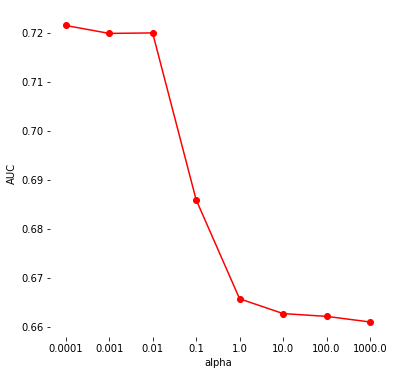

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False) 0.7214635075906752


In [93]:
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
import parfit.parfit as pf

grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'n_iter': [1000], # number of epochs
    'loss': ['log'], # logistic regression,
    'penalty': ['l2'],
    'n_jobs': [-1]
}
paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier, paramGrid,
                                                        X_train, y_train['target'], X_val, y_val['target'], 
                                                        metric = roc_auc_score, scoreLabel = "AUC")

print(bestModel, bestScore)

In [94]:
#Best SGD
x_prediction = X_val
model = bestModel
print("# Training...")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))
print('\n')
x_prediction = X_test
y_prediction = model.predict(x_prediction)
results = y_prediction
prob = pd.DataFrame(data={'SGD prediction': results},index=y_test.index)
Close = pd.DataFrame(data={'SGD Close': y_test['Close']})
prob = prob.join(Close)
prob

# Training...
# Predicting...
- probabilities: [0.80028358 0.36701445 0.21606173 0.58049355 0.31306422]
- accuracy:  0.6366197183098592
- validation logloss: 0.6197400079796849




SGD prediction     SGD Close
2016-05-30               1    528.919983
2016-05-31               1    537.400024
2016-06-01               1    537.099976
2016-06-02               1    567.030029
2016-06-03               1    571.950012
...                    ...           ...
2019-07-16               1   9696.150391
2019-07-17               1  10638.349609
2019-07-18               1  10532.940430
2019-07-19               1  10759.419922
2019-07-20               1  10586.709961

[796 rows x 2 columns]

In [95]:
results = performance(prob['SGD prediction'],prob['SGD Close'])
performance_df['SGD'] = results
performance_df

PCA  Benchmark   PCA_DWT   SGD_PCA       SGD
Sharpe Ratio     0.273371   0.150987  0.246176  0.314941  0.349147
Max Drawdown    -0.960240  -0.960240 -0.960240 -0.960240 -0.960240
Absolute return  0.039091   0.013880  0.019120  0.062899  0.070427

# SGD-PCA

In [96]:
features_target = features.loc[:,'AdrActCnt':'target']
target = features_target['target']
All_features = features_target.drop(columns = ['target'])
Y, X = target,All_features
scaler = MinMaxScaler().fit(X)
rescaledX = scaler.transform(X)
X = pd.DataFrame(rescaledX, index = X.index, columns = X.columns)
Y = pd.DataFrame(Y, index = Y.index)
Y['Close']=features['Close']

In [97]:
#We keep 25 components to make sure the sum of explained variation of the principal components is close to 98%
#To improve accuracy and efficiency
pca = PCA(n_components=25)
X = pd.DataFrame(pca.fit_transform(X),index=X.index)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Sum of Explained variation of principal component: {}'.format(sum(pca.explained_variance_ratio_)))

Explained variation per principal component: [0.57926321 0.15250451 0.05882322 0.03990003 0.03112821 0.02162053
 0.01527704 0.01450557 0.01259834 0.0107622  0.00951225 0.00686194
 0.00616945 0.00430636 0.0037897  0.0031768  0.00291243 0.00267505
 0.00230748 0.0019103  0.00180573 0.00172481 0.00152235 0.00125471
 0.00115054]
Sum of Explained variation of principal component: 0.9874627572556474


In [98]:
#Data Set Preparation 
X_test = X[int(len(X)*0.6):]
X_train = X[:int(len(X)*0.6)]
y_test = Y[int(len(Y)*0.6):]
Y_train = Y[:int(len(Y)*0.6)]
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.3,random_state=42)

print (X_train.shape, y_train.shape)
print (X_val.shape, y_val.shape)

(828, 25) (828, 2)
(355, 25) (355, 2)


-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    2.9s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    2.9s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    2.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    3.0s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    3.0s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    3.0s finished


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    2.7s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.8s finished


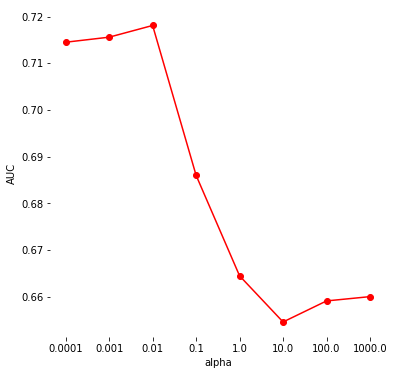

SGDClassifier(alpha=0.01, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False) 0.7181286921171314


In [99]:
grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'n_iter': [1000], # number of epochs
    'loss': ['log'], # logistic regression,
    'penalty': ['l2'],
    'n_jobs': [-1]
}
paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier, paramGrid,
                                                        X_train, y_train['target'], X_val, y_val['target'], 
                                                        metric = roc_auc_score, scoreLabel = "AUC")

print(bestModel, bestScore)

In [100]:
#Best SGD
x_prediction = X_val
model = bestModel
print("# Training...")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))
print('\n')
x_prediction = X_test
y_prediction = model.predict(x_prediction)
results = y_prediction
prob = pd.DataFrame(data={'SGD_PCA prediction': results},index=y_test.index)
Close = pd.DataFrame(data={'SGD_PCA Close': y_test['Close']})
prob = prob.join(Close)
prob

# Training...
# Predicting...
- probabilities: [0.74328116 0.40046884 0.29729714 0.5420427  0.32621966]
- accuracy:  0.6112676056338028
- validation logloss: 0.6252911399947552




SGD_PCA prediction  SGD_PCA Close
2016-05-30                   1     528.919983
2016-05-31                   1     537.400024
2016-06-01                   1     537.099976
2016-06-02                   1     567.030029
2016-06-03                   1     571.950012
...                        ...            ...
2019-07-16                   0    9696.150391
2019-07-17                   1   10638.349609
2019-07-18                   0   10532.940430
2019-07-19                   1   10759.419922
2019-07-20                   1   10586.709961

[796 rows x 2 columns]

In [101]:
results = performance(prob['SGD_PCA prediction'],prob['SGD_PCA Close'])
performance_df['SGD_PCA'] = results
performance_df

PCA  Benchmark   PCA_DWT   SGD_PCA       SGD
Sharpe Ratio     0.273371   0.150987  0.246176  0.302264  0.349147
Max Drawdown    -0.960240  -0.960240 -0.960240 -0.960240 -0.960240
Absolute return  0.039091   0.013880  0.019120  0.050792  0.070427

In [102]:
performance_df = performance_df[['Benchmark','PCA','PCA_DWT','SGD','SGD_PCA']]
performance_df

Benchmark       PCA   PCA_DWT       SGD   SGD_PCA
Sharpe Ratio      0.150987  0.273371  0.246176  0.349147  0.302264
Max Drawdown     -0.960240 -0.960240 -0.960240 -0.960240 -0.960240
Absolute return   0.013880  0.039091  0.019120  0.070427  0.050792

# SVC

In [103]:
features_target = features.loc[:,'AdrActCnt':'target']
target = features_target['target']
All_features = features_target.drop(columns = ['target'])
Y, X = target,All_features
scaler = MinMaxScaler().fit(X)
rescaledX = scaler.transform(X)
X = pd.DataFrame(rescaledX, index = X.index, columns = X.columns)
Y = pd.DataFrame(Y, index = Y.index)
Y['Close']=features['Close']

In [104]:
#Data Set Preparation 
X_test = X[int(len(X)*0.6):]
X_train = X[:int(len(X)*0.6)]
y_test = Y[int(len(Y)*0.6):]
Y_train = Y[:int(len(Y)*0.6)]
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.3,random_state=42)

print (X_train.shape, y_train.shape)
print (X_val.shape, y_val.shape)

(828, 97) (828, 2)
(355, 97) (355, 2)


-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  44 out of  60 | elapsed:    5.6s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  51 out of  60 | elapsed:    6.1s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed:    7.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.3s finished


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.1s finished


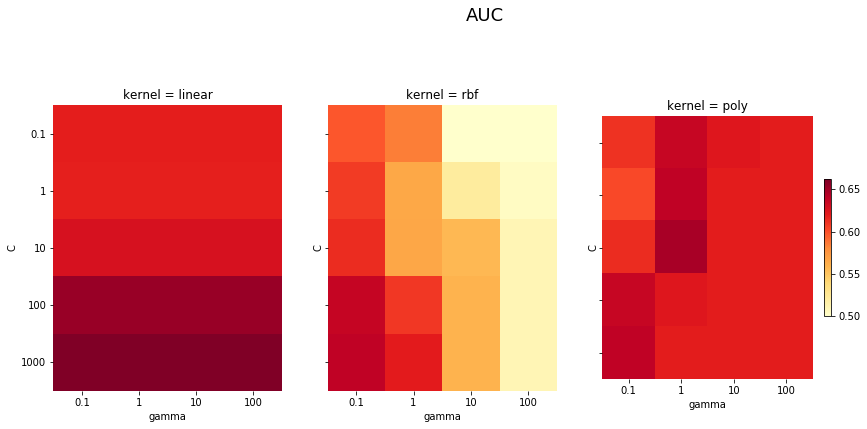

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.6620720320142285


In [105]:
from sklearn.svm import SVC
grid = {
    'kernel': ['linear','rbf','poly'],
    'gamma' : [0.1,1,10,100],
    'C': [0.1,1,10,100,1000],
}
paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(SVC, paramGrid,
                                                        X_train, y_train['target'], X_val, y_val['target'], 
                                                        metric = roc_auc_score, scoreLabel = "AUC")

print(bestModel, bestScore)

In [106]:
#Best SVC
model = bestModel
print("# Training...")
model.fit(X_train, y_train['target'])
print("# Predicting...")
x_prediction = X_test
y_prediction = model.predict(x_prediction)
results = y_prediction
prob = pd.DataFrame(data={'SVC prediction': results},index=y_test.index)
Close = pd.DataFrame(data={'SVC Close': y_test['Close']})
prob = prob.join(Close)

# Training...
# Predicting...


In [107]:
results = performance(prob['SVC prediction'],prob['SVC Close'])
performance_df['SVC'] = results
performance_df

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Benchmark       PCA   PCA_DWT       SGD   SGD_PCA       SVC
Sharpe Ratio      0.150987  0.273371  0.246176  0.349147  0.302264  0.236352
Max Drawdown     -0.960240 -0.960240 -0.960240 -0.960240 -0.960240 -0.960240
Absolute return   0.013880  0.039091  0.019120  0.070427  0.050792  0.020242

# XGB_new

In [108]:
features_target = features.loc[:,'AdrActCnt':'target']
target = features_target['target']
All_features = features_target.drop(columns = ['target'])
Y, X = target,All_features
scaler = MinMaxScaler().fit(X)
rescaledX = scaler.transform(X)
X = pd.DataFrame(rescaledX, index = X.index, columns = X.columns)
Y = pd.DataFrame(Y, index = Y.index)
Y['Close']=features['Close']

In [109]:
#Data Set Preparation 
X_test = X[int(len(X)*0.6):]
X_train = X[:int(len(X)*0.6)]
y_test = Y[int(len(Y)*0.6):]
Y_train = Y[:int(len(Y)*0.6)]
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.3,random_state=42)

print (X_train.shape, y_train.shape)
print (X_val.shape, y_val.shape)

(828, 97) (828, 2)
(355, 97) (355, 2)


-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


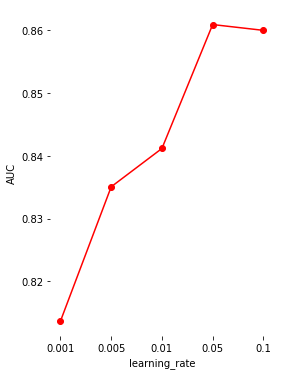

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.05,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1) 0.8608746744584894


In [110]:
grid = {
    'learning_rate':[0.001,0.005,0.01,0.05,0.1],
}
paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(XGBClassifier, paramGrid,
                                                        X_train, y_train['target'], X_val, y_val['target'], 
                                                        metric = roc_auc_score, scoreLabel = "AUC")

print(bestModel, bestScore)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    2.6s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    3.2s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    4.6s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.9s finished


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    2.0s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.1s finished


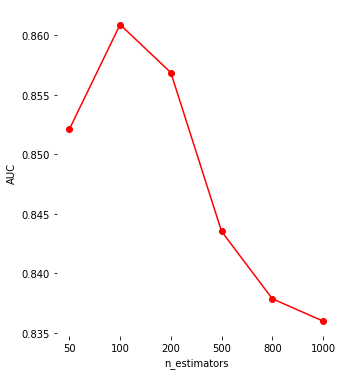

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.05,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1) 0.8608746744584894


In [112]:
grid = {
    'learning_rate':[0.05],
    'n_estimators':[50,100,200,500,800,1000],
}
paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(XGBClassifier, paramGrid,
                                                        X_train, y_train['target'], X_val, y_val['target'], 
                                                        metric = roc_auc_score, scoreLabel = "AUC")

print(bestModel, bestScore)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  16 out of  35 | elapsed:    6.2s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    6.5s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  24 out of  35 | elapsed:    6.9s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  28 out of  35 | elapsed:    8.1s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    8.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    8.5s finished


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.7s finished


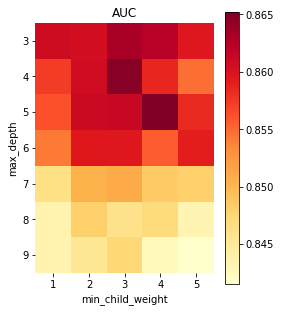

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.05,
       max_delta_step=0, max_depth=5, min_child_weight=4, missing=nan,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1) 0.8652099345740965


In [113]:
grid = {
    'learning_rate':[0.05],
    'n_estimators':[100],
    'max_depth':range(3,10),
    'min_child_weight':range(1,6),
}
paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(XGBClassifier, paramGrid,
                                                        X_train, y_train['target'], X_val, y_val['target'], 
                                                        metric = roc_auc_score, scoreLabel = "AUC")

print(bestModel, bestScore)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.0s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.0s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


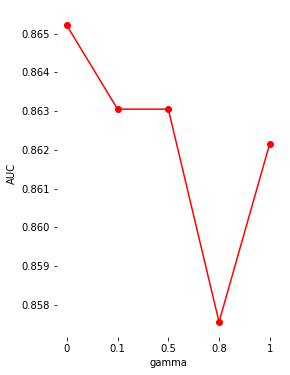

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.05,
       max_delta_step=0, max_depth=5, min_child_weight=4, missing=nan,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1) 0.8652099345740965


In [114]:
grid = {
    'learning_rate':[0.05],
    'n_estimators':[100],
    'max_depth':[5],
    'min_child_weight':[4],
    'gamma' : [0,0.1,0.5,0.8,1]
}
paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(XGBClassifier, paramGrid,
                                                        X_train, y_train['target'], X_val, y_val['target'], 
                                                        metric = roc_auc_score, scoreLabel = "AUC")

print(bestModel, bestScore)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  48 out of  64 | elapsed:    7.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  55 out of  64 | elapsed:    8.6s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  62 out of  64 | elapsed:    9.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:    9.3s finished


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:    3.5s finished


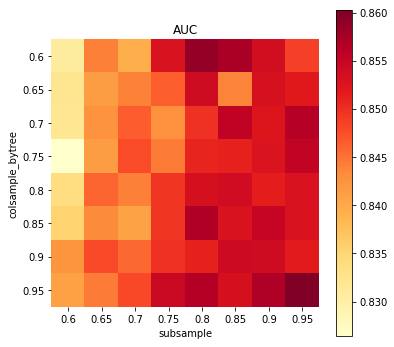

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.95, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=nan, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.95, verbosity=1) 0.8602553515848315


In [115]:
grid = {
    'learning_rate':[0.05],
    'n_estimators':[100],
    'max_depth':[5],
    'min_child_weight':[4],
    'gamma' : [0],
    'subsample':[i/100.0 for i in range(60,100,5)],
    'colsample_bytree':[i/100.0 for i in range(60,100,5)]
}
paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(XGBClassifier, paramGrid,
                                                        X_train, y_train['target'], X_val, y_val['target'], 
                                                        metric = roc_auc_score, scoreLabel = "AUC")

print(bestModel, bestScore)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.7s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.7s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


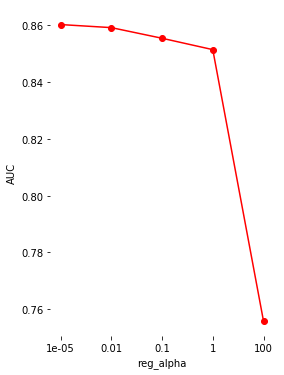

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.95, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=5,
       min_child_weight=4, missing=nan, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.95, verbosity=1) 0.8602553515848315


In [116]:
grid = {
    'learning_rate':[0.05],
    'n_estimators':[100],
    'max_depth':[5],
    'min_child_weight':[4],
    'gamma' : [0],
    'subsample':[0.95],
    'colsample_bytree':[0.95],
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(XGBClassifier, paramGrid,
                                                        X_train, y_train['target'], X_val, y_val['target'], 
                                                        metric = roc_auc_score, scoreLabel = "AUC")

print(bestModel, bestScore)

In [117]:
#Best XGB_new
x_prediction = X_val
model = bestModel
print("# Training...")
model.fit(X_train, y_train['target'])
print("# Predicting...")
y_prediction = model.predict_proba(x_prediction)
probabilities = y_prediction[:, 1]
print("- probabilities:", probabilities[1:6])
correct = [
    round(x) == y
    for (x, y) in zip(probabilities, y_val['target'])
]
print("- accuracy: ", sum(correct) / float(len(y_val['target'])))
print("- validation logloss:",
        metrics.log_loss(y_val['target'], probabilities))
print('\n')
x_prediction = X_test
y_prediction = model.predict(x_prediction)
results = y_prediction
prob = pd.DataFrame(data={'XGB_new prediction': results},index=y_test.index)
Close = pd.DataFrame(data={'XGB_new Close': y_test['Close']})
prob = prob.join(Close)
prob

# Training...
# Predicting...
- probabilities: [0.7358373  0.25141692 0.28025472 0.4403174  0.10369158]
- accuracy:  0.7718309859154929
- validation logloss: 0.4671401878005602




XGB_new prediction  XGB_new Close
2016-05-30                   0     528.919983
2016-05-31                   1     537.400024
2016-06-01                   1     537.099976
2016-06-02                   1     567.030029
2016-06-03                   1     571.950012
...                        ...            ...
2019-07-16                   1    9696.150391
2019-07-17                   1   10638.349609
2019-07-18                   1   10532.940430
2019-07-19                   1   10759.419922
2019-07-20                   1   10586.709961

[796 rows x 2 columns]

In [118]:
results = performance(prob['XGB_new prediction'],prob['XGB_new Close'])
performance_df['XGB_new'] = results
performance_df

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Benchmark       PCA   PCA_DWT       SGD   SGD_PCA       SVC  \
Sharpe Ratio      0.150987  0.273371  0.246176  0.349147  0.302264  0.236352   
Max Drawdown     -0.960240 -0.960240 -0.960240 -0.960240 -0.960240 -0.960240   
Absolute return   0.013880  0.039091  0.019120  0.070427  0.050792  0.020242   

                  XGB_new  
Sharpe Ratio     0.160167  
Max Drawdown    -0.960240  
Absolute return  0.015820